In [3]:
from datasets import load_dataset
from transformers import (AutoModel, AutoTokenizer,
                          BertForTokenClassification, get_linear_schedule_with_warmup, 
                          AdamW, get_scheduler)

import string
import torch
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from ray import tune, train

In [4]:


dataset_name = "Babelscape/multinerd"
model_name = "bert-base-cased" # Basic bert model - cased since the text is cased and it probably helps label entities like "Johnny Depp"

# Set device, also used for hyperparameter search
if torch.cuda.is_available():
    device = "cuda"
    num_gpus = torch.cuda.device_count()
    gpu_per_trial = 1 / num_gpus
    cpu_per_trial = 0
else:
    gpu_per_trial = 0 
    cpu_per_trial = 2  # Something low


tokenizer = AutoTokenizer.from_pretrained(model_name)


# Load data & Remove non-english items

In [5]:

# Loads data, only keeps english, removes language column
dataset_eng = load_dataset(dataset_name).filter(lambda x: x["lang"] == "en").remove_columns("lang")

Found cached dataset json (C:/Users/NicHer/.cache/huggingface/datasets/Babelscape___json/Babelscape--multinerd-f822e910a4f604c0/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\NicHer\.cache\huggingface\datasets\Babelscape___json\Babelscape--multinerd-f822e910a4f604c0\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-eb9ab4cbc9b9233f.arrow
Loading cached processed dataset at C:\Users\NicHer\.cache\huggingface\datasets\Babelscape___json\Babelscape--multinerd-f822e910a4f604c0\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-eed54e3e6216fb0e.arrow
Loading cached processed dataset at C:\Users\NicHer\.cache\huggingface\datasets\Babelscape___json\Babelscape--multinerd-f822e910a4f604c0\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-fe66576485de1b0f.arrow


# Data exploration

### Itos & Stoi

In [24]:
#Mapping from integer labels to strings (from HF dataset repo) and vice versa

stoi = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30,
  }



itos = {value:key for key,value in stoi.items()}

### Plotting

In [23]:

# Uneven class distribution
nercounts = dict(Counter([item for sublist in dataset_eng["train"]["ner_tags"] for item in sublist]))
nercounts

{0: 4957198,
 5: 117330,
 25: 14872,
 26: 4702,
 1: 125974,
 2: 132376,
 13: 17404,
 14: 11608,
 9: 280,
 21: 12162,
 22: 20070,
 6: 48800,
 3: 55282,
 4: 71998,
 27: 5080,
 7: 25472,
 8: 10614,
 15: 5050,
 16: 8406,
 28: 3942,
 11: 5370,
 12: 2972,
 17: 16558,
 18: 6060,
 29: 808,
 30: 956,
 23: 1138,
 24: 202,
 19: 758,
 20: 726,
 10: 70}

In [42]:
# Filter 0 for plotting
nercounts = {k:v for k,v in nercounts.items() if k != 0}

Text(0, 0.5, 'Counts')

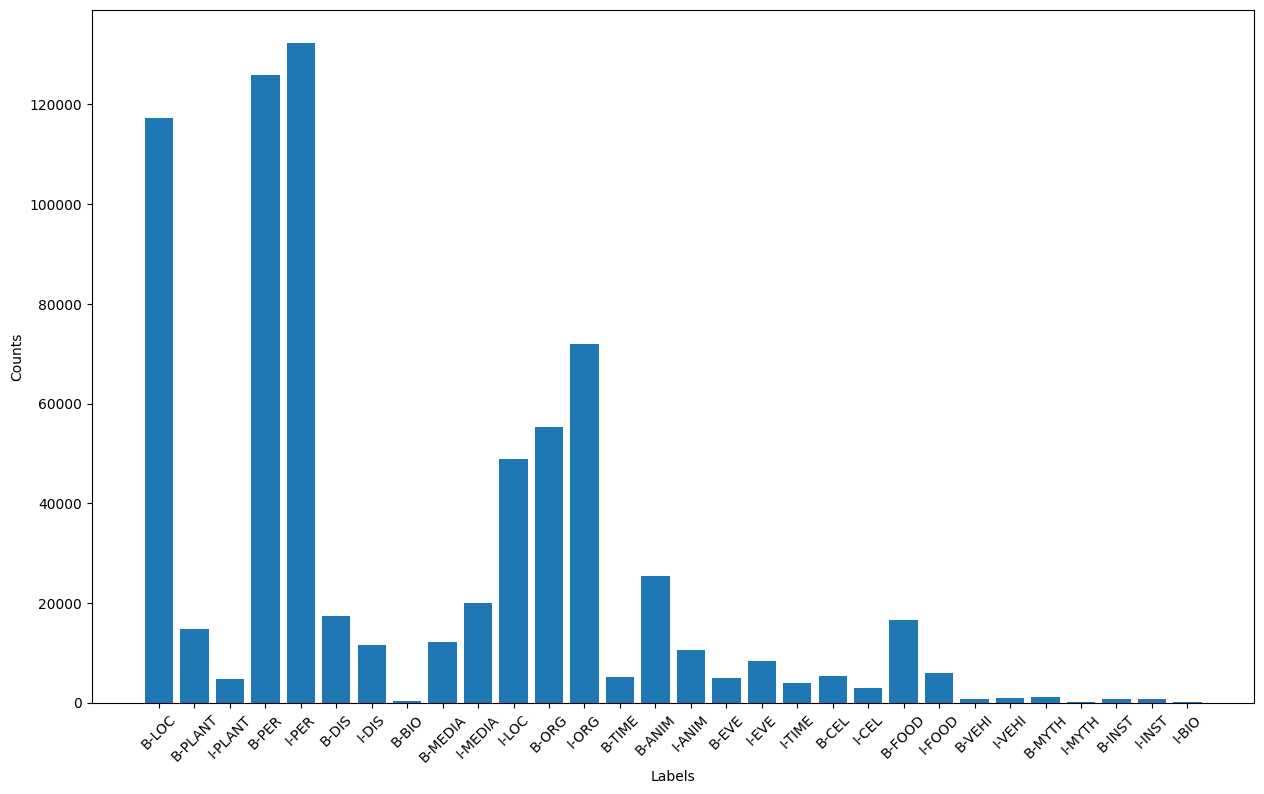

In [48]:
# Bar plots

labels = [itos[x] for x in list(nercounts.keys())]
counts = nercounts.values()

plt.figure(figsize=(15, 9))
plt.bar(labels, counts)

plt.xticks(rotation=45)
plt.xlabel('Labels')
plt.ylabel('Counts')


(array([2.0370e+04, 6.6838e+04, 7.2900e+04, 5.4448e+04, 2.3796e+04,
        1.2156e+04, 6.2960e+03, 2.6360e+03, 1.4500e+03, 7.1200e+02,
        4.1000e+02, 2.1800e+02, 1.3600e+02, 7.0000e+01, 2.6000e+01,
        2.2000e+01, 2.2000e+01, 1.6000e+01, 8.0000e+00, 6.0000e+00,
        6.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  2. ,  10.3,  18.6,  26.9,  35.2,  43.5,  51.8,  60.1,  68.4,
         76.7,  85. ,  93.3, 101.6, 109.9, 118.2, 126.5, 134.8, 143.1,
        151.4, 159.7, 168. , 176.3, 184.6, 192.9, 201.2, 209.5, 217.8,
        226.1, 234.4, 242.7, 251. , 259.3, 267.6, 275.9, 284.2, 292.5,
        300.8, 309.1, 317.4, 325.7, 334. ]),
 <BarContainer object of 40 artists>)

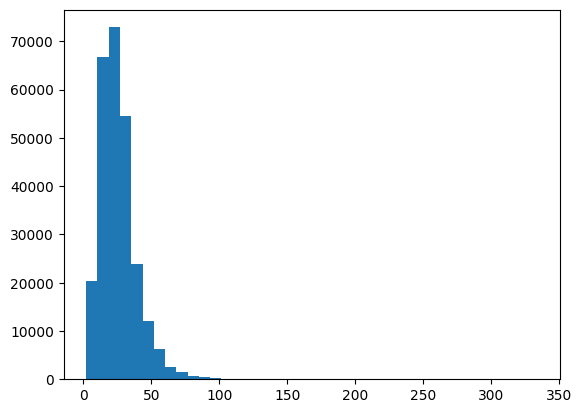

In [79]:
# Most texts are short, can get away with low max token length

tokenized_sent_lengths = [len(tokenizer.tokenize(" ".join(x))) for x in dataset_eng["train"]["tokens"]]

plt.hist(tokenized_sent_lengths, bins=40)

In [82]:
# Around 99 % of sentences are less than 70 tokens
len([x for x in tokenized_sent_lengths if x < 70]) / len(tokenized_sent_lengths)

0.9890158439975625

# Preprocessing

In [8]:



#Taken from HF, to align the ner labels with tokenized words
def align_labels_with_tokens(labels, word_ids, max_length):
    new_labels = []
    current_word = None
    
    # Word ids are mappings between original words and tokens, ie [hej jag heter] => [hej jag het #er] => [0,1,2,2]
    for word_id in word_ids:
        if word_id != current_word:
            # New word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]   #-100 to not take into account during loss function
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)                                #-100 for special tokens
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels[:max_length]    # Truncates labels to match max length



def to_tensor_dataset(data, labels):
    # Effectively zips the data and labels
    inp_ids = data["input_ids"]
    atmask = data["attention_mask"]
    return TensorDataset(inp_ids, atmask, labels)



def label_fix(labels):
    # Input is a nested list of labels
    return [[x if x in [1,2,3,4,5,6,7,8,13,14] else 0 for x in sublist] for sublist in labels]
    



def prepare_data(dataset, splitname, all_labels, max_length=70):
    # Dataset, split, all_labels or subset => Returns torch tensors
    
    splitname = splitname
    sents = dataset[splitname]["tokens"]
    labels = dataset[splitname]["ner_tags"]
    
    # Change labels if all_labels = False
    # A bit slow - would be faster with tensor operations
    if not all_labels:
        labels = label_fix(labels) 
    
    assert len(sents) == len(labels) # Sanity check
    
    # Tokenize and align labels, currently pad everything to the same length
    tokenized_sents = tokenizer(sents, 
                                is_split_into_words=True,   # Input came as lists
                                add_special_tokens=True,    # CLS and SEP
                                padding="max_length",       # Pad shorter sequences
                                truncation=True,            # Truncates longer sequences
                                max_length=max_length,      # Set to 70 by default
                                return_tensors="pt")        # Pytorch tensors
    
    # Stack to turn list of torch tensors into one tensor
    aligned_labels = torch.stack([torch.tensor(
                                 align_labels_with_tokens(labels[i], 
                                 tokenized_sents[i].word_ids, 
                                 max_length)) 
                                 for i in range(len(labels))])
    
    dataset = to_tensor_dataset(tokenized_sents, aligned_labels)
    
    return dataset




all_labels = True

# Tokenizes, aligns labels and turns to torch tensors

training_dataset = prepare_data(dataset_eng, "train", all_labels)
evaluation_dataset = prepare_data(dataset_eng, "validation", all_labels)
testing_dataset = prepare_data(dataset_eng, "test", all_labels)

# Training

In [12]:

# If not all labels, num labels = 11, 2*5 for B and I, + 1 for O
# Else its the length of the label dataset

if not all_labels:
    num_labels = 11
else:
    num_labels = len(itos)
    


# The model probably doesnt need to be more complicated than this, the context is usually very short
model = BertForTokenClassification.from_pretrained("bert-base-cased", 
                                                   num_labels=num_labels, 
                                                   vocab_size=tokenizer.vocab_size, 
                                                   ignore_mismatched_sizes=True).to(device)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:



def ret_dataloaders(training_dataset, evaluation_dataset, batch_size, shuffle=False):
    train_loader = DataLoader(training_dataset, 
                              batch_size=batch_size, 
                              shuffle=shuffle) #False for reproducibility for now
    
    eval_loader = DataLoader(evaluation_dataset,
                             batch_size=batch_size, 
                             shuffle=shuffle) #False for reproducibility for now
    
    return train_loader, eval_loader


def train_epoch(train_loader, scheduler, optimizer, model, hyperparameter_search, i):
    model.train()
    train_loss = 0
    t_lossi = []
    for j,batch in enumerate(train_loader):
        
        _ids, at, lab = batch 
        out = model(input_ids=_ids.to(model.device), 
                    attention_mask=at.to(model.device), 
                    labels=lab.to(model.device)) #   logits = [256, 40, 31] B,T,C, loss is NLL
        train_loss += out.loss.item()

        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(),
                                       max_norm=1) #gradient clipping - safety net

        optimizer.zero_grad() # Zero gradients between each update
        out.loss.backward()   # Calculate gradients
        optimizer.step()      # Step

        if scheduler:         # Update learning rate
            scheduler.step()

        if j % 25 == 0 and j > 0:
            print("Average T loss at step {}: {}".format(j, train_loss / j ))
            if hyperparameter:
                train.report({"step": j,
                              "epoch": i,
                              "training_loss": train_loss / j, 
                              "loss": None}) ##loss needs to be 0 here otherwise error
            
            t_lossi.append(train_loss / j)
            
    
    return model, t_lossi
    


def eval_epoch(eval_loader, model, hyperparameter_search, i):
    model.eval()
    eval_loss = 0
    e_lossi = []
    with torch.no_grad():
        for j,batch in enumerate(eval_loader):
            
            _ids, at, lab = batch
            out = model(input_ids=_ids.to(model.device), 
                        attention_mask=at.to(model.device), 
                        labels=lab.to(model.device))
            eval_loss += out.loss.item()

            if j % 25 == 0 and j > 0:
                print("Average E loss at step {}: {}".format(j, eval_loss / j ))
                if hyperparameter:
                    train.report({"step": j, 
                                  "epoch": i, 
                                  "evaluation_loss": eval_loss / j, 
                                  "loss": None }) ##loss needs to be 0 here otherwise error
                
                e_lossi.append(eval_loss / j )
    #report average evaluation loss to tune
    avg_eval_loss = eval_loss / len(eval_loader)
    if hyperparameter:
        train.report({"loss" : avg_eval_loss})
    return e_lossi




def train_model(params, model, training_dataset, evaluation_dataset, hyperparameter_search=True):
    train_loader, eval_loader = ret_dataloaders(training_dataset, evaluation_dataset, params["batch_size"])
    optimizer = AdamW(params = model.parameters(), lr=params["lr"])
    
    total_steps = (len(training_dataset) // params["batch_size"]) * params["epochs"]
    warmup_steps = int(total_steps * 0.1) #standard 10th
    scheduler = get_scheduler("linear", 
                              optimizer=optimizer, 
                              num_warmup_steps= warmup_steps, ##set warmup steps to 0.1 * total num steps 
                              num_training_steps=total_steps)
    
    
    for i in range(1, params["epochs"] + 1):
        model, t_loss = train_epoch(train_loader, scheduler, optimizer, model, hyperparameter, i)
        e_loss = eval_epoch(eval_loader, model, hyperparameter, i)
        print("epoch: ", i)
        
    
    if not hyperparameter:
        return model





2023-12-14 12:56:32,506	INFO worker.py:1673 -- Started a local Ray instance.
2023-12-14 12:56:38,046	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-12-14 12:56:38,062	INFO tune.py:586 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(train_model pid=6300) C:\Users\NicHer\AppData\Local\anaconda3\envs\envname2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train_model pid=6300)   warnings.warn(


Trial name,loss
train_model_d634a_00000,0.0624402
train_model_d634a_00001,0.0834087
train_model_d634a_00002,0.0691316
train_model_d634a_00003,0.0608448
train_model_d634a_00004,0.0600416
train_model_d634a_00005,0.0910375
train_model_d634a_00006,0.0601074
train_model_d634a_00007,0.0666176
train_model_d634a_00008,0.0730264
train_model_d634a_00009,0.0605143


(train_model pid=8128) Average T loss at step 25: 3.3263437080383302
(train_model pid=8128) Average T loss at step 50: 3.2458693885803225 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train_model pid=6300) Average T loss at step 50: 3.0285105419158938 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 100: 3.138875758647919 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 125: 3.0900346546173094 [repeated 4x across cluster]
(train_model pid=6300) Average T loss at step 100: 2.346327890753746 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 175: 2.9646165711539134 [repeated 4x across cluster]
(train_model pid=11644) Average T loss at step 75: 3.021599639256795 [repeated 4x across cluster]
(train_model pid=6300) Average T loss at step 15

(train_model pid=6300) Average T loss at step 1125: 0.3670826430796749 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 1700: 0.6629995576478541 [repeated 5x across cluster]
(train_model pid=8128) Average T loss at step 1725: 0.6552962166103332 [repeated 4x across cluster]
(train_model pid=11644) Average T loss at step 700: 0.7204160643475396
(train_model pid=6300) Average T loss at step 1175: 0.3549995407196594
(train_model pid=8128) Average T loss at step 1775: 0.6407061423329821 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 1800: 0.6332344754480033 [repeated 4x across cluster]
(train_model pid=6300) Average T loss at step 1225: 0.34292714074919267 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 1850: 0.6187789339234901 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 1875: 0.6119057175949216 [repeated 5x across cluster]
(train_model pid=6300) Average T loss at step 1275: 0.332

(train_model pid=8128) Average T loss at step 3225: 0.38529538127481794 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 3250: 0.38286450090685575 [repeated 5x across cluster]
(train_model pid=6300) Average T loss at step 2200: 0.21855289805071978
(train_model pid=14808) Average T loss at step 2200: 0.25526996691668913
(train_model pid=11644) Average T loss at step 1325: 0.41873900881775145 [repeated 3x across cluster]
(train_model pid=6300) Average T loss at step 2225: 0.21670538681679605 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 3325: 0.3758134165752497 [repeated 3x across cluster]
(train_model pid=6300) Average T loss at step 2250: 0.21493244421549348
(train_model pid=14808) Average T loss at step 2250: 0.25086036229133607
(train_model pid=8128) Average T loss at step 3375: 0.3711182627831413 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 3400: 0.3690476607701481 [repeated 4x across cluster]
(trai

(train_model pid=11644) Average T loss at step 1950: 0.31157034020011243 [repeated 3x across cluster]
(train_model pid=6300) Average T loss at step 3275: 0.16910689604266027 [repeated 2x across cluster]
(train_model pid=6300) Average T loss at step 3300: 0.16842890193618862 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 4925: 0.27409837133050213 [repeated 5x across cluster]
(train_model pid=8128) Average T loss at step 4950: 0.27313195133490037 [repeated 4x across cluster]
(train_model pid=11644) Average T loss at step 2000: 0.30575827667396516
(train_model pid=6300) Average T loss at step 3350: 0.16698682022729278
(train_model pid=8128) Average T loss at step 5000: 0.27113266887401694 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 5025: 0.2701252801164253 [repeated 4x across cluster]
(train_model pid=6300) Average T loss at step 3400: 0.16559150061559835 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 5

(train_model pid=8128) Average T loss at step 6450: 0.22709597314272956 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 6475: 0.22649499460110895 [repeated 5x across cluster]
(train_model pid=7284) Average T loss at step 4375: 0.1832454818806478 [repeated 3x across cluster]
(train_model pid=11644) Average T loss at step 2625: 0.2483347085555572 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 6550: 0.22480752488120126 [repeated 5x across cluster]
(train_model pid=8128) Average T loss at step 6575: 0.22428487930232624 [repeated 4x across cluster]
(train_model pid=6300) Average T loss at step 4450: 0.14258535456783505 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 6625: 0.22319635409993593 [repeated 4x across cluster]
(train_model pid=11644) Average T loss at step 2675: 0.24453798062585852 [repeated 4x across cluster]
(train_model pid=6300) Average T loss at step 4500: 0.14144208339604342 [repeated 2x across

(train_model pid=6300) Average T loss at step 5425: 0.12488899401140137
(train_model pid=14808) Average T loss at step 5425: 0.14046304636408494
(train_model pid=11644) Average T loss at step 3250: 0.20860217962714916 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 8100: 0.1961567905656979 [repeated 5x across cluster]
(train_model pid=14808) Average T loss at step 5475: 0.13942751715064994 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 8150: 0.19555629831552362 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 8175: 0.19521347254522525 [repeated 4x across cluster]
(train_model pid=7284) Average T loss at step 5525: 0.15518907786651442 [repeated 4x across cluster]
(train_model pid=6300) Average T loss at step 5550: 0.12267122356815742 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 8250: 0.19409434286605878 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 

(train_model pid=8128) Average T loss at step 9650: 0.17464483500574715 [repeated 5x across cluster]
(train_model pid=6300) Average T loss at step 6525: 0.10894450252314127
(train_model pid=14808) Average T loss at step 6525: 0.12223714066664884
(train_model pid=8128) Average T loss at step 9700: 0.17415177856980626 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 9725: 0.17388637198815793 [repeated 4x across cluster]
(train_model pid=6300) Average T loss at step 6575: 0.10847616342907797
(train_model pid=11644) Average T loss at step 3925: 0.1816251958833687
(train_model pid=8128) Average T loss at step 9775: 0.17336918370522525 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 9800: 0.17309963412113055 [repeated 4x across cluster]
(train_model pid=6300) Average T loss at step 6625: 0.10795681731822408 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 9850: 0.17250114106885772 [repeated 4x across cluster]
(tra

(train_model pid=8128) Average T loss at step 10875: 0.16038271922642236 [repeated 4x across cluster]
(train_model pid=6300) Average T loss at step 7350: 0.10120183996048433 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 10925: 0.1598192528883492 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 10950: 0.15950516431111858 [repeated 4x across cluster]
(train_model pid=6300) Average T loss at step 7400: 0.10078342962947145 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 11000: 0.15888719077637176 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 11025: 0.15859755285785643 [repeated 5x across cluster]
(train_model pid=6300) Average T loss at step 7450: 0.10038019341972951
(train_model pid=14808) Average T loss at step 7450: 0.11244802440453365
(train_model pid=8128) Average T loss at step 11075: 0.15804367926678123 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at s

(train_model pid=11644) Average T loss at step 675: 0.04061910667965465
(train_model pid=7284) Average E loss at step 325: 0.06729981873685924 [repeated 5x across cluster]
(train_model pid=8128) Average T loss at step 12325: 0.14587295850896623
(train_model pid=6300) Average E loss at step 375: 0.06324833551328629 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 12350: 0.14563407802300363
(train_model pid=7284) Average E loss at step 400: 0.0652976736711571 [repeated 5x across cluster]
(train_model pid=8128) Average T loss at step 12375: 0.14539635400695378
(train_model pid=6300) Average E loss at step 450: 0.06205691840422029 [repeated 4x across cluster]
(train_model pid=11644) Average T loss at step 700: 0.03985593904533224
(train_model pid=8128) Average T loss at step 12400: 0.14519123198313597
(train_model pid=7284) Average E loss at step 475: 0.06388677901245261 [repeated 5x across cluster]
(train_model pid=6300) Average E loss at step 525: 0.059844508685

(train_model pid=13060) C:\Users\NicHer\AppData\Local\anaconda3\envs\envname2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning [repeated 5x across cluster]
(train_model pid=13060)   warnings.warn( [repeated 5x across cluster]


(train_model pid=8128) Average T loss at step 12775: 0.14190403984148564 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 12800: 0.14168348447004064 [repeated 2x across cluster]
(train_model pid=11644) Average T loss at step 875: 0.03773284972146419 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 75: 3.0890517298380535 [repeated 4x across cluster]
(train_model pid=13060) Average T loss at step 100: 2.969348123073578 [repeated 2x across cluster]
(train_model pid=11644) Average T loss at step 900: 0.037523889579460956 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 12900: 0.1407872379710424 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 12925: 0.14054733013762818 [repeated 2x across cluster]
(train_model pid=11644) Average T loss at step 925: 0.03719862752726201 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 200: 2.231892506480217 [repeated 4x across c

(train_model pid=13060) Average T loss at step 1450: 0.4934737644399163 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 1475: 0.48740823648396436 [repeated 2x across cluster]
(train_model pid=11644) Average T loss at step 1450: 0.03540761216555658 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 14275: 0.13134367007321407 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 14300: 0.13121070357817438 [repeated 2x across cluster]
(train_model pid=19352) Average T loss at step 625: 0.7979757864177227 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 1575: 0.46394789441266937 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 1600: 0.45826782942545835 [repeated 2x across cluster]
(train_model pid=11644) Average T loss at step 1500: 0.03535807598712078 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 14400: 0.13062033553672436 [repeated 4x

(train_model pid=8128) Average T loss at step 15650: 0.12374569986976822 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 15675: 0.12364957188495414 [repeated 2x across cluster]
(train_model pid=19352) Average T loss at step 1175: 0.4616457638413982 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 2950: 0.2804951855047385 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 2975: 0.27864358154505087 [repeated 2x across cluster]
(train_model pid=19352) Average T loss at step 1200: 0.45288014319259673 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 15775: 0.12321601992524849 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 15800: 0.12310831764406603 [repeated 2x across cluster]
(train_model pid=19352) Average T loss at step 1225: 0.44569015896898145 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 3075: 0.2721736588730757 [repeated 3x

(train_model pid=8128) Average E loss at step 800: 0.06496654059550565
(train_model pid=13060) Average T loss at step 3900: 0.22782123847088467
(train_model pid=8128) Average E loss at step 825: 0.06655975217516463
(train_model pid=8128) Average E loss at step 850: 0.06591932335784591
(train_model pid=11644) Average T loss at step 2425: 0.03555652589222762
(train_model pid=8128) Average E loss at step 875: 0.0654793121414758
(train_model pid=8128) Average E loss at step 900: 0.06458937959640429
(train_model pid=8128) Average E loss at step 925: 0.06451600746813269
(train_model pid=18772) Average T loss at step 1575: 0.3054158636566902 [repeated 3x across cluster]
(train_model pid=8128) Average E loss at step 950: 0.06409985526830975
(train_model pid=8128) Average E loss at step 975: 0.06348675442392376
(train_model pid=13060) Average T loss at step 3950: 0.2258063721832454
(train_model pid=8128) Average E loss at step 1000: 0.06335262844814861
(train_model pid=13060) Average T loss at 

(train_model pid=13060) Average T loss at step 4650: 0.20022386573109857
(train_model pid=8128) Average T loss at step 350: 0.041329284357572244
(train_model pid=13060) Average T loss at step 4675: 0.1994483826732273 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 4700: 0.19864499126885463 [repeated 4x across cluster]
(train_model pid=13060) Average T loss at step 4725: 0.1977408591930868 [repeated 2x across cluster]
(train_model pid=19352) Average T loss at step 1900: 0.3175894356920923 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 450: 0.04106679420827681 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 4775: 0.19604144375347068
(train_model pid=8128) Average T loss at step 475: 0.04019067072971283
(train_model pid=13060) Average T loss at step 4800: 0.19520720703085923 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 4825: 0.19441548442998852 [repeated 4x across cluster]
(t

(train_model pid=8128) Average T loss at step 1700: 0.038940459167771384 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 6025: 0.16992883189967775
(train_model pid=8128) Average T loss at step 1725: 0.03909015822191419
(train_model pid=13060) Average T loss at step 6050: 0.16949656757916717 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 6075: 0.16908024006958192 [repeated 4x across cluster]
(train_model pid=13060) Average T loss at step 6100: 0.16876676982520605 [repeated 2x across cluster]
(train_model pid=18772) Average T loss at step 2450: 0.22252313680566696 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 1825: 0.03981713846307535 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 6150: 0.16801816820212434
(train_model pid=8128) Average T loss at step 1850: 0.039621223296751454
(train_model pid=13060) Average T loss at step 6175: 0.16766075457872348 [repeated 2x across clust

(train_model pid=18772) Average T loss at step 2950: 0.1925229008459502 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 3075: 0.03296528702954112 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 7400: 0.15140936545429065
(train_model pid=8128) Average T loss at step 3100: 0.03295597100508589
(train_model pid=13060) Average T loss at step 7425: 0.15115706132912243 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 7450: 0.1508733900877 [repeated 4x across cluster]
(train_model pid=13060) Average T loss at step 7475: 0.15068526389811618 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 7500: 0.15046702984794197 [repeated 5x across cluster]
(train_model pid=13060) Average T loss at step 7525: 0.15019002734611517 [repeated 2x across cluster]
(train_model pid=11644) Average T loss at step 3875: 0.030858791463422557 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at ste

(train_model pid=11644) Average E loss at step 425: 0.07602500324630562
(train_model pid=13060) Average T loss at step 8500: 0.14114278194430174 [repeated 3x across cluster]
(train_model pid=11644) Average E loss at step 450: 0.07555905236241718
(train_model pid=13060) Average T loss at step 8525: 0.1410499403485482 [repeated 2x across cluster]
(train_model pid=11644) Average E loss at step 475: 0.07582738708410608
(train_model pid=19352) Average T loss at step 3425: 0.20111126958990783 [repeated 2x across cluster]
(train_model pid=11644) Average E loss at step 500: 0.07499902138020843
(train_model pid=11644) epoch:  2
(train_model pid=8128) Average T loss at step 4250: 0.030498390653233988 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 4275: 0.03049330272475749 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 8600: 0.14047731826899487
(train_model pid=19352) Average T loss at step 3450: 0.20008431752839975
(train_model pid=11644) 

(train_model pid=19352) Average T loss at step 3925: 0.1827096897224261 [repeated 2x across cluster]
(train_model pid=11644) Average T loss at step 500: 0.02319823453866411 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 5525: 0.02875360893847698 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 9850: 0.12914191544019005
(train_model pid=19352) Average T loss at step 3950: 0.18195025612924343
(train_model pid=11644) Average T loss at step 525: 0.022747451046016068 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 9900: 0.12869126781173618 [repeated 3x across cluster]
(train_model pid=19352) Average T loss at step 3975: 0.1812533281184147 [repeated 2x across cluster]
(train_model pid=11644) Average T loss at step 550: 0.02221992456809279 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 5650: 0.02892164225119709 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at st

(train_model pid=19352) epoch:  1
(train_model pid=18772) Average E loss at step 500: 0.06654309184290469
(train_model pid=13060) Average T loss at step 10700: 0.12186658568513824 [repeated 3x across cluster]
(train_model pid=18772) epoch:  1
(train_model pid=13060) Average T loss at step 10725: 0.12164411198661504 [repeated 2x across cluster]
(train_model pid=11644) Average T loss at step 875: 0.018856588975958793 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 6450: 0.028975467288490094 [repeated 4x across cluster]
(train_model pid=13060) Average T loss at step 10775: 0.12124312870846758
(train_model pid=8128) Average T loss at step 6475: 0.028969121955326825
(train_model pid=13060) Average T loss at step 10800: 0.12100784183107828
(train_model pid=11644) Average T loss at step 900: 0.01868326210251932
(train_model pid=13060) Average T loss at step 10825: 0.12081872444718568 [repeated 4x across cluster]
(train_model pid=13060) Average T loss at step 10850: 

(train_model pid=19352) Average T loss at step 575: 0.04550121115986258 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 12150: 0.11107548760806298 [repeated 4x across cluster]
(train_model pid=13060) Average T loss at step 12175: 0.11094688322671782 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 12200: 0.11081217512211043 [repeated 5x across cluster]
(train_model pid=13060) Average T loss at step 12225: 0.1106679825414225 [repeated 2x across cluster]
(train_model pid=19352) Average T loss at step 625: 0.0442294869845733 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 12275: 0.1103480939256502 [repeated 4x across cluster]
(train_model pid=13060) Average T loss at step 12300: 0.11018037404926902 [repeated 2x across cluster]
(train_model pid=13060) Average T loss at step 12325: 0.11001307193202493 [repeated 5x across cluster]
(train_model pid=13060) Average T loss at step 12350: 0.10984716003641098 [repea

(train_model pid=19352) Average T loss at step 1225: 0.03752057560881106 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 9450: 0.02891934989924757 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 13775: 0.10177734483102718
(train_model pid=8128) Average T loss at step 9475: 0.028920912427915564
(train_model pid=13060) Average T loss at step 13800: 0.10166609562288732
(train_model pid=11644) Average T loss at step 2100: 0.017935991151344276
(train_model pid=13060) Average T loss at step 13825: 0.10155673417040217 [repeated 4x across cluster]
(train_model pid=13060) Average T loss at step 13850: 0.10147063300432133 [repeated 2x across cluster]
(train_model pid=19352) Average T loss at step 1275: 0.03757159193238134 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 9575: 0.02888651127999651 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 13900: 0.10126536134721313
(train_model pid=81

(train_model pid=8128) Average T loss at step 10700: 0.02823809387253719 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 15025: 0.09668937495095402
(train_model pid=8128) Average T loss at step 10725: 0.02820625782875064
(train_model pid=11644) Average T loss at step 2600: 0.01763590189441367
(train_model pid=13060) Average T loss at step 15050: 0.0965864188393682
(train_model pid=13060) Average T loss at step 15075: 0.09648286606974078 [repeated 4x across cluster]
(train_model pid=13060) Average T loss at step 15100: 0.09637587338135233 [repeated 2x across cluster]
(train_model pid=19352) Average T loss at step 1775: 0.03851056845373356 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 10825: 0.028063786575753123 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 15150: 0.09618442087716146
(train_model pid=8128) Average T loss at step 10850: 0.02803654036349802
(train_model pid=11644) Average T loss at step 

(train_model pid=13060) Average T loss at step 16275: 0.09257328906020697
(train_model pid=8128) Average T loss at step 11975: 0.026674895930791878
(train_model pid=11644) Average T loss at step 3100: 0.01634839770701928
(train_model pid=13060) Average T loss at step 16300: 0.09249506546520632
(train_model pid=13060) Average T loss at step 16325: 0.09244882080392879 [repeated 4x across cluster]
(train_model pid=13060) Average T loss at step 16350: 0.09238330084692213 [repeated 2x across cluster]
(train_model pid=19352) Average T loss at step 2275: 0.03945438780535299 [repeated 3x across cluster]
(train_model pid=8128) Average T loss at step 12075: 0.02657210254346119 [repeated 3x across cluster]
(train_model pid=13060) Average T loss at step 16400: 0.0922509872800743
(train_model pid=8128) Average T loss at step 12100: 0.02654894410831467
(train_model pid=13060) Average E loss at step 25: 0.05154673225653823
(train_model pid=13060) Average E loss at step 50: 0.062108254111080896
(train

(train_model pid=13060) Average E loss at step 1475: 0.06053315449006346
(train_model pid=13060) Average E loss at step 1500: 0.06064278460646649
(train_model pid=8128) Average T loss at step 12575: 0.026097595759303052
(train_model pid=13060) Average E loss at step 1525: 0.06066654718118876
(train_model pid=8128) Average T loss at step 12600: 0.026060409396875275
(train_model pid=13060) Average E loss at step 1550: 0.060826201101116306
(train_model pid=13060) Average E loss at step 1575: 0.06125020918588335
(train_model pid=13060) Average E loss at step 1600: 0.06149701128819743
(train_model pid=11644) Average T loss at step 3350: 0.015830954825718464
(train_model pid=19352) Average T loss at step 2500: 0.03969893666571006
(train_model pid=13060) Average E loss at step 1625: 0.06143010146318165
(train_model pid=13060) Average E loss at step 1650: 0.06171400365861094
(train_model pid=13060) Average E loss at step 1675: 0.061702218084815894
(train_model pid=8128) Average T loss at step 

(train_model pid=9460) C:\Users\NicHer\AppData\Local\anaconda3\envs\envname2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning [repeated 3x across cluster]
(train_model pid=9460)   warnings.warn( [repeated 3x across cluster]


(train_model pid=8128) Average T loss at step 12825: 0.025798796636807994 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 12850: 0.025764430785732973
(train_model pid=11644) Average T loss at step 3450: 0.015768231512962645
(train_model pid=8128) Average T loss at step 12900: 0.02571492511542686 [repeated 5x across cluster]
(train_model pid=8128) Average T loss at step 12925: 0.02567451762315325
(train_model pid=11644) Average T loss at step 3475: 0.015777122139760708
(train_model pid=8128) Average T loss at step 12950: 0.025643642818195426 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 12975: 0.025611107941904878
(train_model pid=11644) Average T loss at step 3500: 0.01576101081163506
(train_model pid=8128) Average T loss at step 13025: 0.025552516361086155 [repeated 5x across cluster]
(train_model pid=8128) Average T loss at step 13050: 0.025548691401155857
(train_model pid=11644) Average T loss at step 3525: 0.015744261701978537

(train_model pid=8128) Average T loss at step 14575: 0.0249308816878677 [repeated 4x across cluster]
(train_model pid=11644) Average E loss at step 100: 0.08634347418788821
(train_model pid=8128) Average T loss at step 14600: 0.02492015626982583
(train_model pid=11644) Average E loss at step 125: 0.08630823213234544
(train_model pid=19352) Average T loss at step 3300: 0.03583636431612611
(train_model pid=11644) Average E loss at step 150: 0.0881621622821937
(train_model pid=11644) Average E loss at step 175: 0.08717704773215311
(train_model pid=8128) Average T loss at step 14625: 0.024907247852056454 [repeated 3x across cluster]
(train_model pid=11644) Average E loss at step 200: 0.08680909996444824
(train_model pid=8128) Average T loss at step 14650: 0.02491839086625478
(train_model pid=8128) Average T loss at step 14675: 0.02490840569757789
(train_model pid=11644) Average E loss at step 225: 0.08619129962029143
(train_model pid=18772) Average T loss at step 3325: 0.02846931558789482 

(train_model pid=13424) C:\Users\NicHer\AppData\Local\anaconda3\envs\envname2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train_model pid=13424)   warnings.warn(


(train_model pid=9460) Average T loss at step 875: 0.4196419049517385 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 15025: 0.024775457714039086 [repeated 4x across cluster]
(train_model pid=8128) Average T loss at step 15050: 0.024763862461620746 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 15075: 0.024750362039735012 [repeated 5x across cluster]
(train_model pid=8128) Average T loss at step 15100: 0.024736986517784183 [repeated 2x across cluster]
(train_model pid=19352) Average T loss at step 3500: 0.0356711617896799 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 15150: 0.0247179568326653 [repeated 5x across cluster]
(train_model pid=8128) Average T loss at step 15175: 0.02470650057969517 [repeated 2x across cluster]
(train_model pid=8128) Average T loss at step 15200: 0.024698326549466736 [repeated 5x across cluster]
(train_model pid=8128) Average T loss at step 15225: 0.024682255689469922 [repeate

(train_model pid=8128) Average E loss at step 275: 0.07246674036814842
(train_model pid=8128) Average E loss at step 300: 0.07125493289937973
(train_model pid=8128) Average E loss at step 325: 0.06938390111381662
(train_model pid=13424) Average T loss at step 1525: 0.3964298050368174 [repeated 2x across cluster]
(train_model pid=8128) Average E loss at step 350: 0.0736359970801381
(train_model pid=8128) Average E loss at step 375: 0.07199260267561962
(train_model pid=13424) Average T loss at step 1550: 0.39199186232722094
(train_model pid=8128) Average E loss at step 400: 0.07102874400027759
(train_model pid=8128) Average E loss at step 425: 0.07206736051740283
(train_model pid=19352) Average T loss at step 4075: 0.03580953810786817
(train_model pid=8128) Average E loss at step 450: 0.07138966271096757
(train_model pid=8128) Average E loss at step 475: 0.07151404958897681
(train_model pid=8128) Average E loss at step 500: 0.0712341302140485
(train_model pid=18772) Average T loss at ste

(train_model pid=13424) Average T loss at step 2450: 0.2785932881392215 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 2500: 0.2743579735694919 [repeated 4x across cluster]
(train_model pid=18772) Average T loss at step 175: 0.017054845578303293 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 2575: 0.2683489617566099 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 2600: 0.2663947360138767 [repeated 3x across cluster]
(train_model pid=9460) Average T loss at step 1925: 0.23131369901869397 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 2675: 0.2607492918589492 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 2700: 0.2590070310742508
(train_model pid=9460) Average T loss at step 1950: 0.22940957892518968
(train_model pid=13424) Average T loss at step 2750: 0.2552024925199168 [repeated 3x across cluster]
(train_model pid=18772) Average T loss at step 

(train_model pid=13424) Average T loss at step 5000: 0.16901879090495642 [repeated 4x across cluster]
(train_model pid=18772) Average T loss at step 1175: 0.013954568464455116 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 5075: 0.16769456703418847 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 5125: 0.16685469226731078 [repeated 4x across cluster]
(train_model pid=18772) Average T loss at step 1225: 0.013788370002484025 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 5200: 0.16537510332921207 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 5250: 0.16444197411687733 [repeated 4x across cluster]
(train_model pid=13424) Average T loss at step 5275: 0.16386907494043207 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 5325: 0.16286038616139817 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 5375: 0.16197950200633643 [repeat

(train_model pid=13424) Average T loss at step 7500: 0.13711317936972095 [repeated 3x across cluster]
(train_model pid=18772) Average T loss at step 2175: 0.01382571719283768 [repeated 3x across cluster]
(train_model pid=9460) Average T loss at step 3900: 0.1389437755106244 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 7600: 0.13635363881071833 [repeated 3x across cluster]
(train_model pid=9460) Average T loss at step 3925: 0.13844085388784266 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 7675: 0.1358574551371524 [repeated 3x across cluster]
(train_model pid=18772) Average T loss at step 2250: 0.01363612646423927 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 7750: 0.135333646146881 [repeated 2x across cluster]
(train_model pid=18772) Average T loss at step 2275: 0.013579805688862178 [repeated 3x across cluster]
(train_model pid=9460) Average T loss at step 4000: 0.13694566467075492 [repeated 2x ac

(train_model pid=13424) Average T loss at step 9425: 0.12203240999028048 [repeated 3x across cluster]
(train_model pid=18772) Average T loss at step 2950: 0.012657315717017085 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 9500: 0.12149324069353507 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 9525: 0.12129252566352212
(train_model pid=18772) Average T loss at step 2975: 0.012601996290904936
(train_model pid=13424) Average T loss at step 9575: 0.12094511865836376 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 9625: 0.12060525134890099 [repeated 4x across cluster]
(train_model pid=18772) Average T loss at step 3025: 0.0125027133451514 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 9700: 0.12018408410361255 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 9750: 0.11987335812529394 [repeated 4x across cluster]
(train_model pid=18772) Average T los

(train_model pid=13424) Average T loss at step 12100: 0.10346464269705649 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 12125: 0.10333195508482323
(train_model pid=13424) Average T loss at step 12150: 0.10321220500087734
(train_model pid=13424) Average T loss at step 12175: 0.10310146919779266 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 12200: 0.1029790924306299
(train_model pid=18772) Average T loss at step 4050: 0.011573617192056032
(train_model pid=13424) Average T loss at step 12250: 0.10273917946079628 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 12275: 0.10258804691510058
(train_model pid=18772) Average T loss at step 4075: 0.011565195704937806
(train_model pid=13424) Average T loss at step 12325: 0.10230596020456822 [repeated 3x across cluster]
(train_model pid=18772) Average E loss at step 25: 0.08881085896864534
(train_model pid=13424) Average T loss at step 12350: 0.10215765165904446 

(train_model pid=13424) Average T loss at step 14425: 0.09243446653220456 [repeated 3x across cluster]
(train_model pid=9460) Average T loss at step 2375: 0.029665087628018994 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 14525: 0.09209882209539431 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 14575: 0.09191064909207662 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 14625: 0.09170954397468306 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 14675: 0.09157586552348965 [repeated 3x across cluster]
(train_model pid=9460) Average T loss at step 2475: 0.029610596044457076 [repeated 2x across cluster]
(train_model pid=13424) Average T loss at step 14775: 0.09120399686091168 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 14825: 0.09102118622094356 [repeated 3x across cluster]
(train_model pid=13424) Average T loss at step 14875: 0.09086170019353877 [

(train_model pid=13424) Average E loss at step 950: 0.06178595611854689
(train_model pid=9460) Average T loss at step 3275: 0.026027134925998813
(train_model pid=13424) Average E loss at step 975: 0.06131116287846966
(train_model pid=13424) Average E loss at step 1000: 0.06107075118301145
(train_model pid=13424) Average E loss at step 1025: 0.06040668117074103
(train_model pid=13424) Average E loss at step 1050: 0.06004540131281828
(train_model pid=13424) Average E loss at step 1075: 0.06036604486145945
(train_model pid=13424) Average E loss at step 1100: 0.06074113377851476
(train_model pid=13424) Average E loss at step 1125: 0.06037683802439521
(train_model pid=13424) Average E loss at step 1150: 0.06041645998702101
(train_model pid=9460) Average T loss at step 3300: 0.025982460259414933
(train_model pid=13424) Average E loss at step 1175: 0.06050227888562578
(train_model pid=13424) Average E loss at step 1200: 0.060519534492050296
(train_model pid=13424) Average E loss at step 1225:

2023-12-14 16:50:17,890	INFO tune.py:1047 -- Total run time: 14019.83 seconds (14019.79 seconds for the tuning loop).


(train_model pid=9460) epoch:  2


In [ ]:
    

# Random search of some hyperparameters using ray.tune

analysis = tune.run(
            tune.with_parameters(
                train_model,                               # Name of function - normally trainer.train
                model=model,                               # Model input
                training_dataset=training_dataset,         # Syntax
                evaluation_dataset=evaluation_dataset,      # Syntax
                hyperparameter_search=True,
            ),
            resources_per_trial={
                "gpu": gpu_per_trial,                                 # Only gpu, Can set to decimals for simultaneous trials
                "cpu": cpu_per_trial
            },
            config={
                "lr": tune.choice([2e-5, 3e-5, 5e-5]),     # Per original bert paper
                "batch_size": tune.choice([16, 32, 64]),   # Batch sizes to test
                "epochs": tune.choice([1,2,3]),            # Epoch choices
                    }, 
            num_samples=10,                                # Total number of trials
            metric="loss",                                 # The metric to optimize - loss on evaluation set
            mode="min"                                     # As low as possible
            )



In [20]:
best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best hyperparameters found were: ", best_config)

Best hyperparameters found were:  {'lr': 5e-05, 'batch_size': 32, 'epochs': 1}


In [ ]:
dfs = analysis.trial_dataframes

plt.figure(figsize=(15, 9))
for trial_id, df in dfs.items():
    plt.plot(df['step'], df['evaluation_loss'], label=f'Trial {trial_id}')
    plt.plot(df['step'], df['training_loss'], label=f'Trial {trial_id}')
    
plt.xlabel('Steps')
plt.ylabel('Evaluation Loss')
plt.title('Evaluation Loss Over Steps')
plt.legend()
plt.show()

In [1]:
model = train_model(best_config, model, training_dataset, evaluation_dataset, hyperparameter=False)

NameError: name 'analysis' is not defined

# Evaluation

In [87]:



def test(test_loader):
    model.eval()
    predictions, labels = [], []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            _ids, at, lab = batch
            out = model(input_ids=_ids.to(model.device), attention_mask=at.to(model.device)) 

            #print(out.logits.shape)  #dim 2 are predictions for each input
            preds = torch.argmax(out.logits, dim=2)


            # Only compare indicies where there is not padding or special tokens
            mask = (lab != -100) #& (lab != 0)

            # Also test with mask = lab != 0, since the class is so large

            # Retrieve correct indices
            preds = preds[mask]
            labs = lab[mask]

            # Tolist for comparison
            predictions.extend(preds.tolist())
            labels.extend(labs.tolist())
    
    return predictions, labels


#accuracy is high, because most are just 0
#sum([1 for x,y in zip(predictions, labels) if x==y]) / len(labels)

test_loader = DataLoader(testing_dataset, batch_size=64, shuffle=False)
preds, labels = test(test_loader)


In [89]:
sum([1 for x,y in zip(preds, labels) if x==y]) / len(labels)

0.20498089101601538

In [ ]:


cm = metrics.confusion_matrix([itos[x] for x in labels], [itos[x] for x in predictions])

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
## precison - how many of the tags were correctly predicted
## recall - h
## f1